In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns; sns.set()
import scipy.stats as stats
import datetime as dt

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score, r2_score

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [3]:
def Wind_Dir(df, dir):
    Wind_dir=pd.get_dummies(df[dir])
    wind_directions = [column for column in Wind_dir]
    north=dir+"_N"
    south=dir+"_S"
    west=dir+"_W"
    east=dir+"_E"
    df.insert(len(df.columns), north, 0)
    df.insert(len(df.columns), south, 0)
    df.insert(len(df.columns), west, 0)
    df.insert(len(df.columns), east, 0)
    for direction in wind_directions:
        if "N" in direction:
            df[north]+=Wind_dir[direction]
        if "S" in direction:
            df[south]+=Wind_dir[direction]
        if "W" in direction:
            df[west]+=Wind_dir[direction]
        if "E" in direction:
            df[east]+=Wind_dir[direction]
    
    df=df.drop(dir, axis=1)
    return df

def promedio(df, v1, v2, nombre, skipna):
    df_prom=df[[v1, v2]]
    df[nombre] = df_prom.mean(axis=1, skipna=skipna)
    return df

In [4]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

In [5]:
def guarda_metricas(nombre_modelo, X_train, X_test, y_train, y_test, results):
    r=call_metrics(y_test, predicciones)
    acc=r["Accuracy"]
    prec=r["Precision"]
    rec=r["Recall"]
    F1=r["F1"]
    results=results.append({"Modelo": nombre_modelo, "RobustScaler": scaler, "PCA": PCA, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": F1}, ignore_index=True)
    return results

In [6]:
def k_folds(X_train, y_train, C, max_iter, class_weight):
    k=5    
    # Definimos el modelo a emplear
    l_regression = LogisticRegression(C=C, max_iter=max_iter, class_weight=class_weight)

    # Definimos una métrica
    error = F1()

    chunk_size = int(len(X_train) / k)
    F1_list = []

    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])
        
        l_regression.fit(new_X_train, new_y_train)
        prediction = l_regression.predict(new_X_valid)
        k_error = error(new_y_valid, prediction)
        F1_list.append(k_error)
        # print("Modelo {i} de {k}, Métrica: {error}".format(i=i/chunk_size, k=k, error=k_error))
        
    mean_F1 = np.mean(F1_list)

    return mean_F1

In [7]:
######### Carga datos de dataset
path = r"C:/Especializacion IA/2do_bim/tp/weatherAUS.csv"
df = pd.read_csv(path, sep=',',engine='python')

###### Creo la variable Rainfall_tomorrow. 
df['Rainfall_tomorrow']=df['Rainfall'].shift(-1)
max_date = df["Date"].max()
delete = np.where(df.Date==max_date)
### dropeo el ultimo del dataset porque no tiene información de mañana.
df = df.drop(df[(df['Date']==max_date)].index)

In [8]:
total_samples = len(df)
cities = pd.unique(df.Location)
total_cities = len(cities)

In [9]:
##### Comienzo One Hot Encoding con algunas cuestiones del dataframe completo.
df["Month"]=pd.to_datetime(df["Date"]).dt.month
df=df.replace(to_replace="Yes", value=1)
df=df.replace(to_replace="No", value=0)

In [10]:
##### de los datos de lluvia por mes se puede ver para agrupar en: verano meses 12, 1, 2, otoño 3,4,5,6  invierno 7,8,9 , primavera 10,11

Month = pd.get_dummies(df["Month"])
df["Verano"]=Month[12]+Month[1]+Month[2]
df["Otoño"]=Month[3]+Month[4]+Month[5]+Month[6]
df["Invierno"]=Month[7]+Month[8]+Month[9]
df["Primavera"]=Month[10]+Month[11]
df=df.drop("Month", axis=1)

In [11]:
##### Evaluamos las variables categóricas de dirección de viento.
df = Wind_Dir(df, "WindGustDir")
df = Wind_Dir(df, "WindDir9am")
df = Wind_Dir(df, "WindDir3pm")
df.shape

(145412, 37)

In [12]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="gps_australia")

In [13]:
import re

df_locations = pd.DataFrame(columns=["City","Latitude","Longitude"])
i=0
for city in cities:
    ######## Hago una transformación de la ciudad en: "Australia"+ un split de la Ciudad donde tiene mayúsculas.
    ###### Esto es porque el nombre completo no es identificable por Geopy. Además, agrego "Australia" porque sino algunos resultados son de otros países.
    ### El único problema hasta ahí es PearceRAAF, que tiene muchas mayúsculas pero RAAF no debe separarse, entonces hago un chequeo de la longitud del String.
    result=re.sub( r"([A-Z])", r" \1", city).split()
    new_city="Australia "
    for strn in result:
        if len(strn)>1:
            new_city=new_city+strn+" "
        else:
            new_city=new_city+strn
    location=geolocator.geocode(new_city)
    df_locations.loc[i]=[city, location.latitude,location.longitude]  
    i+=1

print(df_locations.head())


            City   Latitude   Longitude
0         Albury -36.080477  146.916280
1  BadgerysCreek -33.881667  150.744163
2          Cobar -31.498333  145.834444
3   CoffsHarbour -30.296241  153.113529
4          Moree -29.461720  149.840715


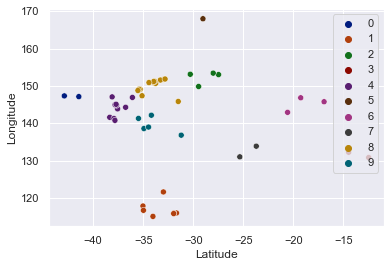

In [14]:
### uso Kmeans para clusterizar las ciudades.
X=df_locations.drop("City", axis=1)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
sns.scatterplot(x="Latitude", y="Longitude", data=df_locations, hue=kmeans.labels_, palette="dark")
### joineo los labels a df_locations
df_locations = pd.concat([df_locations, pd.DataFrame(data=kmeans.labels_, columns=["Cluster"])], axis=1, join="inner")

In [15]:
for city in cities:
    df=df.replace(to_replace=city, value=str(np.array(df_locations.loc[df_locations.City==city]["Cluster"])))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindGustDir_W,WindGustDir_E,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir9am_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,WindDir3pm_E
0,2008-12-01,[4],13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,1,0,0,0,1,0,1,0,1,0
1,2008-12-02,[4],7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,1,0,1,0,1,0,0,1,1,0
2,2008-12-03,[4],12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,1,0,0,0,1,0,0,1,1,0
3,2008-12-04,[4],9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,0,1,0,1,0,1,0,0,0,1
4,2008-12-05,[4],17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,1,0,1,0,0,1,1,0,1,0


In [16]:
location = pd.get_dummies(df["Location"])
df= pd.concat([df, location], axis=1, join="inner")
df= df.drop("Location", axis=1)
df.shape

(145412, 46)

In [17]:
######### Divido en subsets de entrenamiento y test.
df_1 = df.sample(frac=1)
df_1 = df_1.reset_index(drop=True)
y=df_1["RainTomorrow"]
X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size=0.2, random_state=1,shuffle=False)
X_train.shape, X_test.shape

((116329, 46), (29083, 46))

In [18]:
X_train=X_train.drop(["Evaporation", "Sunshine"], axis=1)
X_train.shape

(116329, 44)

In [19]:
X_train["Amplitud_Temp"]=(X_train["MaxTemp"]-X_train["MinTemp"])

In [20]:
X_train = promedio(X_train, "Pressure9am", "Pressure3pm", "Pressure", True)
X_train=X_train.drop(["Pressure9am", "Pressure3pm"], axis=1)

In [21]:
##### Para seguir analizando relaciones entre datos es necesario ya imputar los datos faltantes
##### Comienzo por dropear Cloud9am y Cloud3pm. Tienen una cantidad de datos faltantes muy importante.
X_train=X_train.drop(["Cloud9am","Cloud3pm"],axis=1)

In [22]:
### Termino de acomodar las columnas de X_train. Saco además RainTomorrow y Rainfall_tomorrow.
X_train=X_train.drop(["Date","MinTemp","MaxTemp","Temp9am","Temp3pm"],axis=1)

In [23]:
#### no voy a imputar valores correspondientes a lluvias. De eso se encargará el modelo a entrenar.
X_train=X_train.dropna(subset=['Rainfall', 'Rainfall_tomorrow','RainToday','RainTomorrow'])
X_train.shape

(112568, 37)

In [24]:
from sklearn.impute import SimpleImputer

def impute_by_mean(X_t, column):
    X_train=X_t.copy()
    imputer = SimpleImputer(strategy='mean',add_indicator=True)
    X_train[column] = imputer.fit_transform(X_train[column].values.reshape(-1, 1))
    return X_train, imputer

In [25]:
cols=["Humidity9am","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Amplitud_Temp"]
X_means = pd.DataFrame(columns=cols)
for column in cols:
    X_train, X_means.loc[0,column]=impute_by_mean(X_train,column)

In [26]:
###########3 IMPUTACION POR KNN
from sklearn.impute import KNNImputer
def impute_by_KNN2(X_t, n):
    X_train=X_t.copy()
    imputer = KNNImputer(n_neighbors=n)
    X_KNN = imputer.fit_transform(X_train)
    X_KNN = pd.DataFrame(data=X_KNN, columns=X_train.columns, index=X_train.index)
    return X_KNN,imputer

In [27]:
neighbors=5
Xt2, KNN_imputer=impute_by_KNN2(X_train[["Pressure","Humidity3pm","Amplitud_Temp"]],neighbors)

In [28]:
for column in ["Pressure","Humidity3pm"]:
    X_train[column]=Xt2[column]

In [29]:
y_train=X_train["RainTomorrow"]
y_train_reg=X_train["Rainfall_tomorrow"]
X_train=X_train.drop(["RainTomorrow","Rainfall_tomorrow"],axis=1)

In [30]:
# from sklearn.feature_selection import mutual_info_regression

# MI = mutual_info_regression(X_train, y_train_reg)
# MI = pd.DataFrame(data=100*MI,index=X_train.columns)
# MI

In [31]:
def poner_a_tono(df):
    df["Amplitud_Temp"]=df["MaxTemp"]-df["MinTemp"]
    df=promedio(df, "Pressure9am", "Pressure3pm", "Pressure", True)
    cols_to_drop=["Date","MinTemp","MaxTemp","Cloud9am","Cloud3pm","Temp9am","Temp3pm","Pressure3pm","Pressure9am", "Evaporation","Sunshine"]
    df=df.drop(cols_to_drop, axis=1)
    #### empezamos a ver los NaNs.
    df=df.dropna(subset=['Rainfall', 'Rainfall_tomorrow','RainToday','RainTomorrow'])
     ## imputaciones por mediana
    for col in ["Humidity9am","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Amplitud_Temp"]:
        df[col] = X_means.loc[0,col].transform(df[col].values.reshape(-1,1))
    ### imputaciones por KNN
    df2=KNN_imputer.transform(df[["Pressure","Humidity3pm","Amplitud_Temp"]])
    df.loc[:,"Pressure"]=df2[:,0]
    df.loc[:,"Humidity3pm"]=df2[:,1]
    
    return df   

In [32]:
X_train=X_train.drop(["Verano", "Invierno","Otoño","Primavera"], axis=1)
X_test=X_test.drop(["Verano", "Invierno","Otoño","Primavera"], axis=1)

In [33]:
X_test=poner_a_tono(X_test)

In [34]:
y_test=X_test["RainTomorrow"]
y_test_reg=X_test["Rainfall_tomorrow"]
X_test=X_test.drop(["Rainfall_tomorrow","RainTomorrow"],axis=1)

In [55]:
def reg_lineal(X_train, X_test, y_train_reg, y_test_reg):
    y_train_reg = y_train_reg.values.reshape(-1,1)
    y_test_reg = y_test_reg.values.reshape(-1,1)
    
    # Estandarizamos
    scaler = RobustScaler(quantile_range=(5, 95))
    scaler_y = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train_reg)
    
    # aplicamos estandarizacion a Test
    X_test_scaled=scaler.transform(X_test)
    y_test_scaled=scaler_y.transform(y_test_reg)
    
    #reg. lineal de sklearn
    lin_reg = LinearRegression(normalize=True).fit(X_scaled, y_scaled)
    #metrica
    mse=MSE()
    #score del train
    train_predicciones = lin_reg.predict(X_scaled)
    y_pred_train = scaler_y.inverse_transform(train_predicciones)
    y_pred_train[y_pred_train<0]=0
    y_real_train = scaler_y.inverse_transform(y_scaled)
    mse_train = mse(y_pred_train, y_real_train)
    score_train = r2_score(y_real_train, y_pred_train)
    print("Train:")
    print(mse_train, score_train)
    
    #predicciones
    pred_scaled = lin_reg.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(pred_scaled)
    y_pred[y_pred<0]=0
    mse_test = mse(y_pred, y_test_reg)
    score_test = r2_score(y_test_reg, y_pred)
    print("Test:")
    print(mse_test, score_test)
    
    rn = np.linspace(0, len(y_test_scaled),len(y_test_scaled))
    plt.plot(rn, y_test_reg, 'r')
    plt.plot(rn, y_pred, 'y')
    plt.show()
    
    return np.array([mse_train, score_train, mse_test, score_test]).T

In [65]:
def ridge_reg(X_train, X_test, y_train_reg, y_test_reg, alpha):
    y_train_reg = y_train_reg.values.reshape(-1,1)
    y_test_reg = y_test_reg.values.reshape(-1,1)
    
    # Estandarizamos
    scaler = RobustScaler(quantile_range=(5, 95))
    scaler_y = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train_reg)
    
    # aplicamos estandarizacion a Test
    X_test_scaled=scaler.transform(X_test)
    y_test_scaled=scaler_y.transform(y_test_reg)
    
    #reg. lineal de sklearn
    lin_reg = Ridge(alpha=alpha, normalize=True).fit(X_scaled, y_scaled)
    #metrica
    mse=MSE()
    #score del train
    train_predicciones = lin_reg.predict(X_scaled)
    y_pred_train = scaler_y.inverse_transform(train_predicciones)
    y_pred_train[y_pred_train<0]=0
    y_real_train = scaler_y.inverse_transform(y_scaled)
    mse_train = mse(y_pred_train, y_real_train)
    score_train = r2_score(y_real_train, y_pred_train)
    print("Train:")
    print(mse_train, score_train)
    
    #predicciones
    pred_scaled = lin_reg.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(pred_scaled)
    y_pred[y_pred<0]=0
    mse_test = mse(y_pred, y_test_reg)
    score_test = r2_score(y_test_reg, y_pred)
    print("Test:")
    print(mse_test, score_test)
    
    rn = np.linspace(0, len(y_test_scaled),len(y_test_scaled))
    plt.plot(rn, y_test_reg, 'r')
    plt.plot(rn, y_pred, 'y')
    plt.show()
    
    return np.array([mse_train, score_train, mse_test, score_test]).T  

In [82]:
def lasso_reg(X_train, X_test, y_train_reg, y_test_reg, alpha):
    y_train_reg = y_train_reg.values.reshape(-1,1)
    y_test_reg = y_test_reg.values.reshape(-1,1)
    
    # Estandarizamos
    scaler = RobustScaler(quantile_range=(5, 95))
    scaler_y = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train_reg)
    
    # aplicamos estandarizacion a Test
    X_test_scaled=scaler.transform(X_test)
    y_test_scaled=scaler_y.transform(y_test_reg)
    
    #reg. lineal de sklearn
    lin_reg = Ridge(alpha=alpha, normalize=True).fit(X_scaled, y_scaled)
    #metrica
    mse=MSE()
    #score del train
    train_predicciones = lin_reg.predict(X_scaled)
    y_pred_train = scaler_y.inverse_transform(train_predicciones)
    y_pred_train[y_pred_train<0]=0
    y_real_train = scaler_y.inverse_transform(y_scaled)
    mse_train = mse(y_pred_train, y_real_train)
    score_train = r2_score(y_real_train, y_pred_train)
    print("Train:")
    print(mse_train, score_train)
    
    #predicciones
    pred_scaled = lin_reg.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(pred_scaled)
    y_pred[y_pred<0]=0
    mse_test = mse(y_pred, y_test_reg)
    score_test = r2_score(y_test_reg, y_pred)
    print("Test:")
    print(mse_test, score_test)
    
    rn = np.linspace(0, len(y_test_scaled),len(y_test_scaled))
    plt.plot(rn, y_test_reg, 'r')
    plt.plot(rn, y_pred, 'y')
    plt.show()
    
    return np.array([mse_train, score_train, mse_test, score_test]).T  

In [83]:
columns=["MSE_train", "R2_train","MSE_test","R2_test"]
resultados=pd.DataFrame(index=columns)

Train:
55.51838894286921 0.20682447658147973
Test:
53.17365693687011 0.21176878796055665


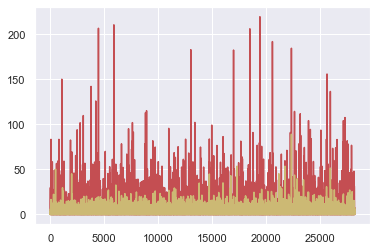

In [84]:
df2=pd.DataFrame(reg_lineal(X_train, X_test, y_train_reg, y_test_reg), index=columns, columns=["Reg. Lineal"])
resultados=pd.concat([resultados, df2], axis=1, join="inner")

Train:
55.97980688128843 0.20023232897436927
Test:
53.666840093649114 0.20445798069584498


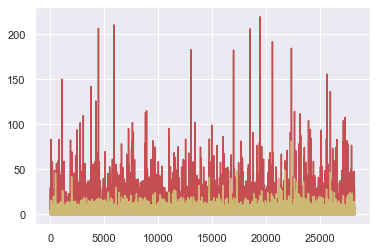

Train:
57.59592473362154 0.1771433102215122
Test:
55.318186499583355 0.17997888984467614


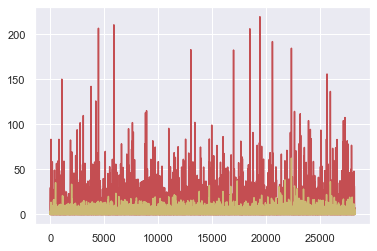

Train:
58.971158131567094 0.15749573955153862
Test:
56.68347419752052 0.1597402521635174


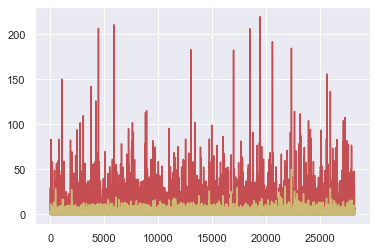

Train:
63.88314827109085 0.08731952543349941
Test:
61.48857256338066 0.08851083656422187


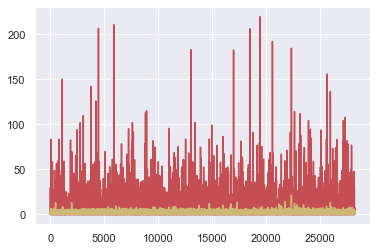

Train:
66.06296177247724 0.05617714634364346
Test:
63.61605733168254 0.05697360564732268


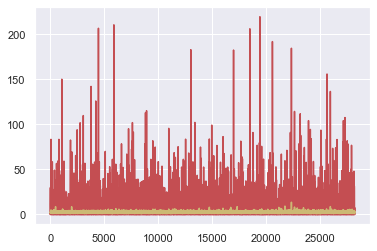

In [85]:
for alpha in [0.1, 0.5, 1, 5, 10]:
    df2=pd.DataFrame(ridge_reg(X_train, X_test, y_train_reg, y_test_reg, alpha), index=columns, columns=["Ridge alpha="+str(alpha)])
    resultados=pd.concat([resultados, df2], axis=1, join="inner")

Train:
55.97980688128843 0.20023232897436927
Test:
53.666840093649114 0.20445798069584498


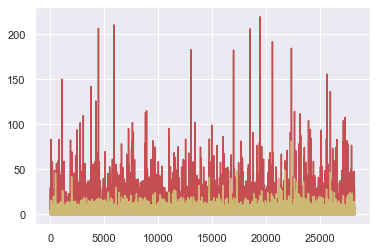

Train:
57.59592473362154 0.1771433102215122
Test:
55.318186499583355 0.17997888984467614


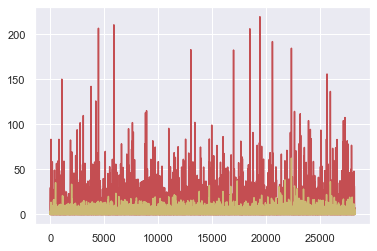

Train:
58.971158131567094 0.15749573955153862
Test:
56.68347419752052 0.1597402521635174


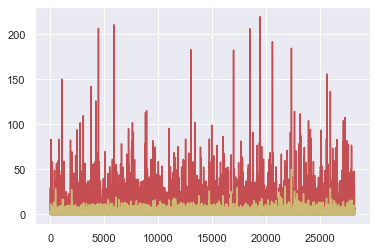

Train:
63.88314827109085 0.08731952543349941
Test:
61.48857256338066 0.08851083656422187


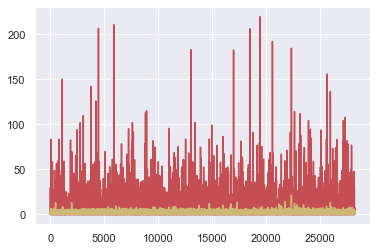

Train:
66.06296177247724 0.05617714634364346
Test:
63.61605733168254 0.05697360564732268


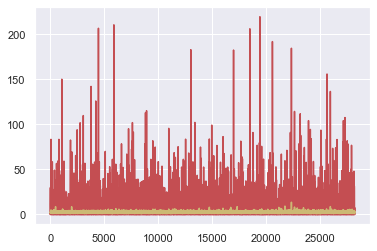

In [86]:
for alpha in [0.1, 0.5, 1, 5, 10]:
    df2=pd.DataFrame(lasso_reg(X_train, X_test, y_train_reg, y_test_reg, alpha), index=columns, columns=["Lasso alpha="+str(alpha)])
    resultados=pd.concat([resultados, df2], axis=1, join="inner")

Train:
55.23907635648168 0.2108149365195966
Test:
51.997442468150794 0.2292046577070681


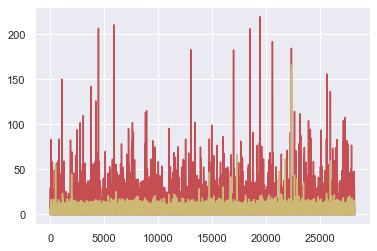

In [87]:
X2_train = X_train ** 2
X2_test = X_test ** 2
df2=pd.DataFrame(reg_lineal(X2_train, X2_test, y_train_reg, y_test_reg), index=columns, columns=["Reg. sólo térm cuad."])
resultados=pd.concat([resultados, df2], axis=1, join="inner")

Train:
47.63776983191218 0.3194126533498579
Test:
46.63878588295288 0.30863986337795946


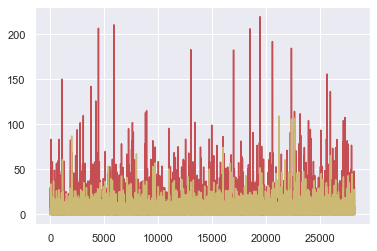

In [88]:
poly = PolynomialFeatures(2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.transform(X_test)
df2=pd.DataFrame(reg_lineal(X_train2, X_test2, y_train_reg, y_test_reg), index=columns, columns=["Reg. Polin. 2°"])
resultados=pd.concat([resultados, df2], axis=1, join="inner")

Train:
39.6883349685709 0.4329839813129329
Test:
52.82285446794515 0.21696898428324785


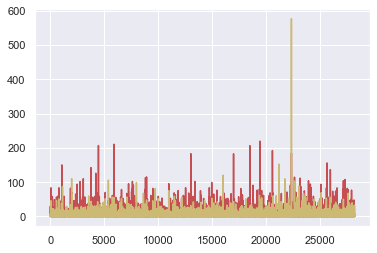

In [89]:
poly = PolynomialFeatures(3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.transform(X_test)
df2=pd.DataFrame(reg_lineal(X_train3, X_test3, y_train_reg, y_test_reg), index=columns, columns=["Reg. Polin. 3°"])
resultados=pd.concat([resultados, df2], axis=1, join="inner")

In [90]:
resultados

,Reg. Lineal,Ridge alpha=0.1,Ridge alpha=0.5,Ridge alpha=1,Ridge alpha=5,Ridge alpha=10,Lasso alpha=0.1,Lasso alpha=0.5,Lasso alpha=1,Lasso alpha=5,Lasso alpha=10,Reg. sólo térm cuad.,Reg. Polin. 2°,Reg. Polin. 3°
MSE_train,55.518389,55.979807,57.595925,58.971158,63.883148,66.062962,55.979807,57.595925,58.971158,63.883148,66.062962,55.239076,47.637770,39.688335
R2_train,0.206824,0.200232,0.177143,0.157496,0.087320,0.056177,0.200232,0.177143,0.157496,0.087320,0.056177,0.210815,0.319413,0.432984
MSE_test,53.173657,53.666840,55.318186,56.683474,61.488573,63.616057,53.666840,55.318186,56.683474,61.488573,63.616057,51.997442,46.638786,52.822854
R2_test,0.211769,0.204458,0.179979,0.159740,0.088511,0.056974,0.204458,0.179979,0.159740,0.088511,0.056974,0.229205,0.308640,0.216969
